<a href="https://colab.research.google.com/github/neurorishika/pod-96-manymanifolds/blob/master/Population%20Spike%20Code%20Approach/motorencodingneuralmanifolds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor encoding on neural manifolds in different brain regions
##### Project Contributors: Narotam Singh, Vaibhav, Rishika Mohanta, Prakriti Nayak

##### Done as part of [Neuromatch Academy](https://github.com/NeuromatchAcademy/course-content/blob/master/projects/load_steinmetz_decisions.ipynb) July 13-31 2020

In [1]:
#@title Import Modules
import numpy as np
from sklearn.linear_model import LinearRegression,SGDRegressor,RidgeCV
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import r2_score
import pandas as pd
from numpy.random import default_rng

In [2]:
#@title Helper functions
def sampler(data, N = 50, Train_N = 80, Test_N = 20, brain_region = None):  ## Samples for each Session
  rng = default_rng()
  trial_index = rng.choice(data['spks'].shape[1], size=100, replace=False)
  if brain_region:
    data_temp = data['spks'][data['brain_area']==brain_region,:,:]
  else:
    data_temp = data['spks']
  neuron_index = rng.choice(data_temp.shape[0], size=50, replace=False)
  train_trial_index = trial_index[0:Train_N]
  test_trial_index = trial_index[Train_N:-1 ]
  return neuron_index, train_trial_index, test_trial_index

def get_relevant_trial(data, neuron_idx, idx, start, end):
    motion = data["wheel"][0][idx]
    spikes = data["spks"][neuron_idx, idx,:]
    return spikes[:,start:end], motion[start:end]

def train_loop(data, neuron_index, train_trial_index, test_trial_index, d = 10, select_motion = True):  ## Samples for each Session
  start = int(data["stim_onset"]/data["bin_size"])
  model = RidgeCV()#SGDRegressor(penalty='l2')
  
  X_train,y_train = [],[]
  for idx in train_trial_index:
    end = int((data["stim_onset"]+data["gocue"][idx])/data["bin_size"])
    X_train_part, y_train_part = get_relevant_trial(data, neuron_index, idx, start, end)
    X_train_part = designmatrix(X_train_part,d = d)
    X_train.append(X_train_part)
    y_train.append(y_train_part)
  
  X_train = np.concatenate(X_train)
  y_train = np.concatenate(y_train)  
  model.fit(X_train,y_train)
  y_pred = model.predict(X_train)
  r2_value_train = r2_score(y_train, y_pred)
  rvalue_train = linregress(y_train,y_pred).rvalue

  X_test,y_test = [],[]
  for idx in test_trial_index:
    end = int((data["stim_onset"]+data["gocue"][idx])/data["bin_size"])
    X_test_part, y_test_part = get_relevant_trial(data, neuron_index, idx, start, end)
    X_test_part = designmatrix(X_test_part,d = d)  
    X_test.append(X_test_part)
    y_test.append(y_test_part)
    
  X_test = np.concatenate(X_test)
  y_test = np.concatenate(y_test)  
  y_pred = model.predict(X_test)
  r2_value = r2_score(y_test, y_pred)
  rvalue = linregress(y_test,y_pred).rvalue

  return model, r2_value, rvalue

def designmatrix(X,d=20):
   #print(X.shape)
   padded_stim = np.column_stack((np.zeros((X.shape[0],d-1)),X))
   X_design = np.zeros((X.shape[1],d*X.shape[0]))
   for t in range(X.shape[1]):
     X_design[t] = padded_stim[:,t:t+d].flatten()
   return np.column_stack((np.ones(X.shape[1]),X_design))


##Data retreival and Loading

In [3]:
alldata = np.load('train.npz', allow_pickle=True)['arr_0']

Take a look at the data

In [4]:
for i in range(len(alldata)):
  dat = alldata[i]
  print(f"index {i}  brain areas {set(dat['brain_area'])} Neurons {dat['spks'].shape[0]}")

index 0  brain areas {'MOs'} Neurons 113
index 1  brain areas {'MOs', 'VPL'} Neurons 164
index 2  brain areas {'VPL', 'CP'} Neurons 165
index 3  brain areas {'MOs'} Neurons 112
index 4  brain areas {'VPL'} Neurons 73
index 5  brain areas {'MOp', 'CP'} Neurons 722
index 6  brain areas {'MD'} Neurons 126
index 7  brain areas {'MOs'} Neurons 186
index 8  brain areas {'VPM'} Neurons 162
index 9  brain areas {'VPM'} Neurons 60
index 10  brain areas {'CP', 'SNr'} Neurons 287
index 11  brain areas {'MOp', 'SSp'} Neurons 377
index 12  brain areas {'MOs'} Neurons 65
index 13  brain areas {'SCig'} Neurons 366
index 14  brain areas {'MOs', 'SCig'} Neurons 266
index 15  brain areas {'MOs', 'SCig'} Neurons 356
index 16  brain areas {'MOs'} Neurons 97
index 17  brain areas {'SCig'} Neurons 65
index 18  brain areas {'MOp', 'CP', 'SSp'} Neurons 750
index 19  brain areas {'MD', 'VPM'} Neurons 255
index 20  brain areas {'MOs', 'SNr'} Neurons 398
index 21  brain areas {'SCm', 'MOs'} Neurons 125
index 22 

In [5]:
from tqdm import tqdm 
#df = pd.DataFrame()
#best_d_dict = {}
result = []
for jj in tqdm(range(3)):
  result = []
  for i in range(len(alldata)):
    dat = alldata[i]
    ba = set(dat['brain_area'])
    #ba_d = []
    for bb in ba:
      neuron_index, train_trial_index, test_trial_index = sampler(dat, brain_region = bb)
      # Finding optimal 'd' for every brain region.
      best_d, best_coff, best_r2 = -1, 0, -np.inf
      
      for d in range(6, 25):
        #neuron_index, train_trial_index, test_trial_index = sampler(dat, brain_region = bb)
        try:
          model, r2, corr_coeff = train_loop(dat, neuron_index, train_trial_index, test_trial_index, d)
        except:
          pass
        if r2 > best_r2 :
          best_d, best_r2 = d, r2

      for _ in range(10):
        neuron_index, train_trial_index, test_trial_index = sampler(dat, brain_region = bb)
        try:
          model, r2, corr_coeff = train_loop(dat, neuron_index, train_trial_index, test_trial_index, best_d)
          result.append([jj, i, bb, best_d, [neuron_index], [train_trial_index], [test_trial_index], model, corr_coeff ,r2])
                  
        except:
          pass
df = pd.DataFrame(result)
df.columns = ["Exp_No","#Session_Number", "Brain_Areas", "Optimal_d", "#Neurons_Used","Train_index", "Test_index", "Model", "Correlation_Coefficient","R2_score"]

df.to_csv('result.csv', index=False)

100%|██████████| 3/3 [1:49:06<00:00, 2182.10s/it]


In [7]:
df.head()

,Exp_No,#Session_Number,Brain_Areas,Optimal_d,#Neurons_Used,Train_index,Test_index,Model,Correlation_Coefficient,R2_score
0,2,0,MOs,12,"[[30, 52, 2, 81, 59, 20, 73, 82, 25, 26, 103, ...","[[35, 109, 167, 168, 98, 90, 91, 56, 52, 153, ...","[[122, 100, 10, 92, 82, 9, 137, 51, 68, 18, 15...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.396349,0.102805
1,2,0,MOs,12,"[[84, 74, 25, 96, 67, 2, 5, 57, 58, 26, 35, 13...","[[37, 126, 20, 88, 114, 79, 119, 120, 102, 118...","[[62, 117, 71, 112, 127, 53, 124, 159, 160, 10...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.665079,0.428462
2,2,0,MOs,12,"[[97, 35, 31, 107, 16, 33, 63, 83, 80, 82, 55,...","[[109, 47, 163, 63, 11, 17, 135, 133, 156, 112...","[[86, 91, 77, 92, 58, 104, 167, 158, 13, 45, 8...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.730384,0.451404
3,2,0,MOs,12,"[[0, 31, 52, 16, 87, 94, 23, 8, 3, 112, 108, 8...","[[35, 88, 122, 98, 57, 126, 5, 65, 85, 79, 73,...","[[82, 30, 93, 4, 160, 123, 7, 12, 68, 81, 86, ...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.786849,0.614614
4,2,0,MOs,12,"[[48, 105, 4, 8, 43, 99, 71, 42, 77, 82, 27, 6...","[[137, 43, 150, 22, 89, 63, 122, 16, 59, 4, 57...","[[129, 128, 40, 116, 110, 94, 9, 19, 11, 124, ...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.614128,0.292905


## Result Analysis

In [8]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(-1.0, 1.0)

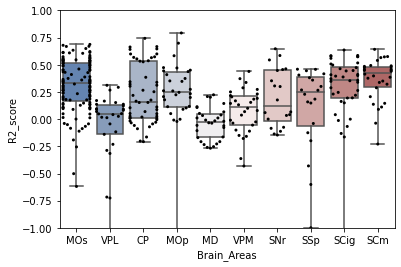

In [10]:
sns.boxplot(x='Brain_Areas',y='R2_score',data=df,whis=[0, 100], palette="vlag")
sns.swarmplot(x='Brain_Areas',y='R2_score',data=df, size=3, color="k", linewidth=0)
plt.ylim((-1,1))

(-1.0, 1.0)

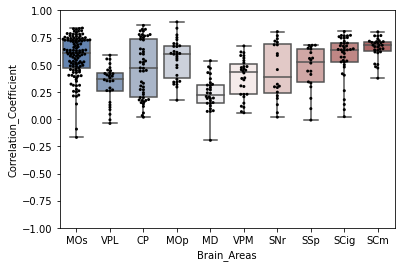

In [12]:
sns.boxplot(x='Brain_Areas',y='Correlation_Coefficient',data=df,whis=[0, 100], palette="vlag")
sns.swarmplot(x='Brain_Areas',y='Correlation_Coefficient',data=df, size=3, color="k", linewidth=0)
plt.ylim((-1,1))

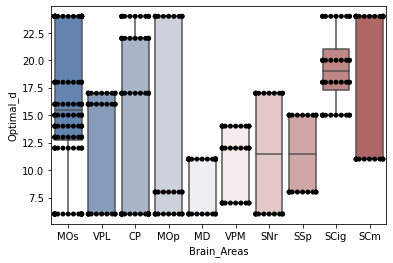

In [14]:
sns.boxplot(x='Brain_Areas',y='Optimal_d',data=df,whis=[0, 100], palette="vlag")
sns.swarmplot(x='Brain_Areas',y='Optimal_d',data=df, size=5, color="k", linewidth=0)

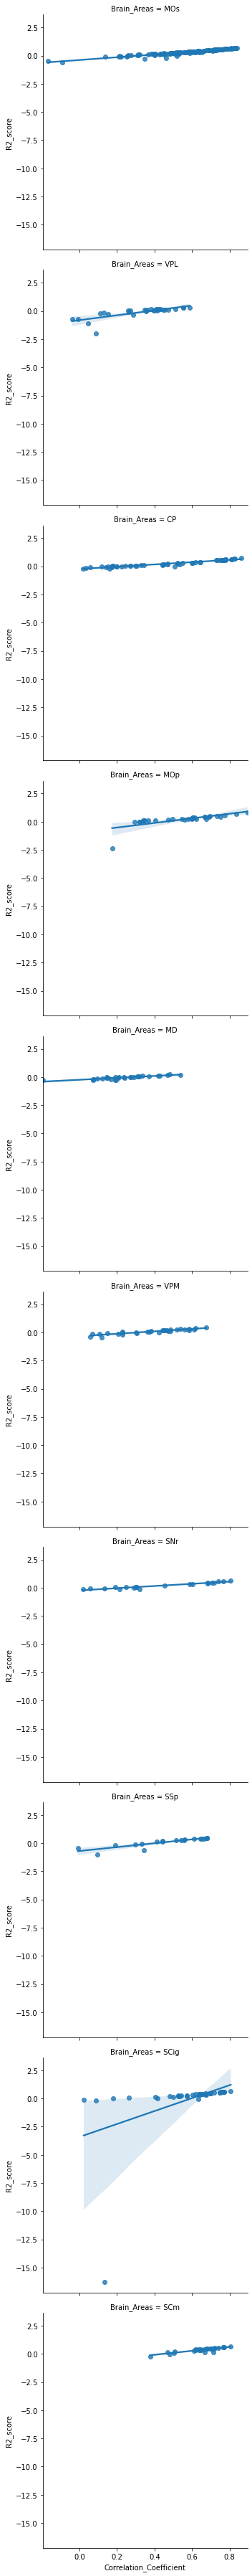

In [16]:
sns.lmplot('Correlation_Coefficient','R2_score',data=df,row='Brain_Areas')

(array([90., 20., 30., 30., 20., 50., 50., 10., 10., 90.]),
 array([ 6. ,  7.8,  9.6, 11.4, 13.2, 15. , 16.8, 18.6, 20.4, 22.2, 24. ]),
 <a list of 10 Patch objects>)

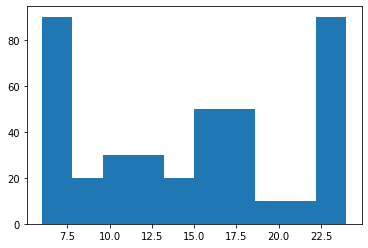

In [18]:
plt.hist(df.Optimal_d)

In [20]:
np.mean(df.Optimal_d)

14.775

In [23]:
pos = 0
kernel_space = df.Model[pos].coef_[1:]

In [25]:
KSX = np.array(np.split(kernel_space,50))

Let us now view it. Since it is not possible to view so many dimensions, we make use of the dimensionality reduction techniques:
* t-SNE
* PCA

And see the results as obtained from our model

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [28]:
TSNEmodel = TSNE(n_components=2)
PCAmodel = PCA(n_components=3)

In [29]:
transformed_tsne = TSNEmodel.fit_transform(KSX)
transformed_pca = PCAmodel.fit_transform(KSX)

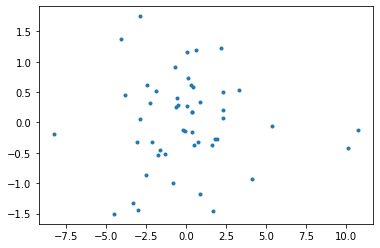

In [31]:
plt.plot(transformed_pca[:,0],transformed_pca[:,1],'.')

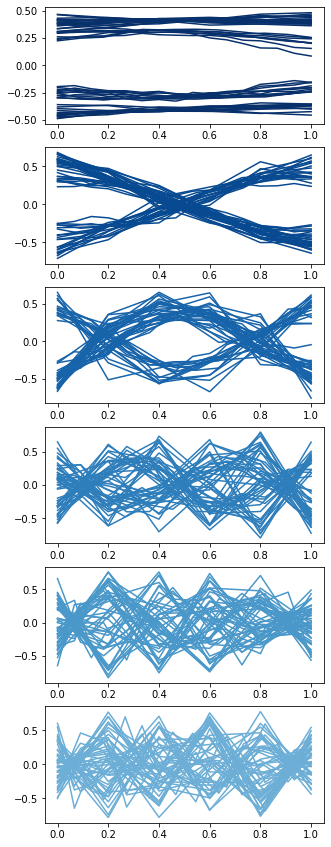

In [33]:
plt.figure(figsize=(5,15))
for i in range(0,6):
    plt.subplot(6,1,i+1)
    for pos in range(50):
        kernel_space = df.Model[pos].coef_[1:]
        KSX = np.array(np.split(kernel_space,50))
        if KSX.shape[1]<=5:
            continue
        PCAmodel = PCA()
        transformed_pca = PCAmodel.fit_transform(KSX)
        plt.plot(np.linspace(0,1,PCAmodel.components_[i].shape[0]),PCAmodel.components_[i],color=plt.cm.Blues_r(i/10),label=f'{i+1}')

In [35]:
df.Model[pos].coef_[1:].shape

(300,)